# Analyze the Meaty Portions of Job Descriptions

- Compare the meaty portion of job descriptions to our exhaustive list of skills

## Approach 1: Manual Comparison to Large List of Skills

List derived from a variety of online sources.

In [1]:
skills = []
with open('/Users/goodgame/Desktop/Shift/match/reqs/analysis/unique_skills_augmented.txt', 'r') as skillsfile:
    for line in skillsfile:
        skills.append(line.strip())

    
print("Sample skills:\n", sorted(skills[:10]))

print("\nNumber of skills in list:\n", len(skills))


Sample skills:
 ['adobe premiere', 'arcnet', 'hottomale', 'ibm tso/spf', 'mobile ui design', 'nextstep', 'political science', 'snax hls', 'software design', 'vietnamese']

Number of skills in list:
 2589


In [2]:
import re

In [3]:
# turn a file into a single string
with open('/Users/goodgame/Desktop/Shift/match/reqs/jobs_text_meat_only/uber/Uber_1--Technical-Writer---Internship_Co-Op---San-Francisco--Ca---Uber---Uber.Txt.txt', 'r') as infile:
    uber_example = infile.read()
print(uber_example)

Uber 1--Technical-Writer---Internship_Co-Op---San-Francisco--Ca---Uber---Uber.Txt




the technical writing team is in engineering and increases developer efficiency and productivity. as a technical writer intern this summer, you will use your writing and technical abilities to
make it fun and easy to find, understand, and share engineering information
. you'll work with engineers, technical writers, product managers, and data scientists to understand user needs.

we are looking for an intern to join us in summer 2018.
work closely with engineers to produce technical documentation that other engineers trust.
improve existing onboarding and education processes with documentation, helping engineers contribute quicker.
properly organize documentation, from the layout of content on a page to finding its proper place in the entire documentation taxonomy, with search optimization in mind.
define standards and style guidelines that help other writers, as well as engineers. you will be a stewa

In [4]:
all_skills_dict = {}

# Regex to match a substring within a larger string -- but only at the beginning or end of a word.
# This is to prevent skills that are only a letter or two (like 'R') from showing up 100K times.
def string_found(string1, string2):
    if re.search(r"\b" + re.escape(string1) + r"\b", string2):
        return True
    return False
with open('/Users/goodgame/Desktop/Shift/match/reqs/jobs_text_meat_only/uber/Uber_1--Technical-Writer---Internship_Co-Op---San-Francisco--Ca---Uber---Uber.Txt.txt', 'r') as infile:
    for line in infile:
        for skill in skills:
            if string_found(skill, line):
                if skill not in all_skills_dict:
                    all_skills_dict[skill] = 1
                else:
                    all_skills_dict[skill] += 1
                    
def sort_dict(d):
    s = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    for k, v in s:
        print(k, "\t", v)
        
sort_dict(all_skills_dict)                    


writing 	 5
engineering 	 5
documentation 	 5
technical documentation 	 3
technical writing 	 2
as 	 2
quality 	 2
demonstrated ability 	 2
technical writer 	 1
developer 	 1
product 	 1
data scientists 	 1
product managers 	 1
work closely 	 1
education 	 1
layout 	 1
well 	 1
science 	 1
english 	 1
data science 	 1
statistics 	 1
computer science 	 1
biology 	 1
chemistry 	 1
physics 	 1
software 	 1
web 	 1


# Term Frequency-Inverse Document Frequency

A different approach.


http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


### Purpose
1. There's a lot of value in just organizing the data in terms of td-idf values.
2. We can go a bit down the rabbit hole of creating models to predict which _company_ a JD is written for. It's worth noting that the JD texts themselves often contain the job title (which includes the company name), so maybe we shouldn't include those lines. Alternatively, we could remove the company names from the corpus through stopwords. (That's the current method.)

In [5]:
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation as cv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm


from stop_words import get_stop_words

import numpy as np
import pandas as pd

import codecs
import os
import time

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
#CONNECTING TO THE DATASET
CORPUS_ROOT = "/Users/goodgame/desktop/Shift/match/reqs/jobs_text_meat_only/"

def load_data(root=CORPUS_ROOT):
    """
    Loads the text data into memory using the bundle dataset structure.
    Note that on larger corpora, memory safe CorpusReaders should be used.
    """

    # Open the README and store
    with open(os.path.join(root, 'README'), 'r') as readme:
        DESCR = readme.read()

    # Iterate through all the categories
    # Read the HTML into the data and store the category in target
    data      = []
    target    = []
    filenames = []

    for category in os.listdir(root):
        if category == "README": continue # Skip the README
        if category == ".DS_Store": continue # Skip the .DS_Store file
        for doc in os.listdir(os.path.join(root, category)):
            fname = os.path.join(root, category, doc)

            # Store information about document
            filenames.append(fname)
            target.append(category)
            with codecs.open(fname, 'r', 'ISO-8859-1') as f:
                data.append(f.read())
            # Read data and store in data list
            # with open(fname, 'r') as f:
            #     data.append(f.read())

    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=frozenset(target),
        DESCR=DESCR,
    )

dataset = load_data()

#print out the readme file
print(dataset.DESCR)
#Remember to create a README file and place it inside your CORPUS ROOT directory if you haven't already done so.

#print the number of records in the dataset
print("The number of instances is ", len(dataset.data), "\n")

#Checking out the data
print("Here are the last five instances: \n\n")
for item in dataset.data[-5:]:
    print(item, "\n\n\n")

print("Here are the categories of the last five instances: \n")
for item in dataset.target[-5:]:
    print(item, "\n\n")

This is a corpus of job descriptions.

They have been stripped of any boilerplate text, leaving behind only the text specific to a given job.

In other words, lines like "Here at Uber, we believe in..." have been removed.

Additionally, lines "introducing" meaty job description text have been removed. Here are some examples:
- "About you:"
- "Required Skills"
- "What You'll Need"

The number of instances is  1352 

Here are the last five instances: 


Affirm Data Scientist - Machine Learning

affirm is a technology and data-driven finance company. we are mining vast amounts of data to successfully rewrite the rules on how credit is evaluated. our data scientists play an absolutely pivotal role in the company, writing the models that allow us to evaluate the creditworthiness of our users in unprecedentedly holistic, efficient, and accurate ways.
build production fraud and credit machine learning models; your models will decide who we lend to in real time
conduct ad-hoc data analyses; yo

### Feature Engineering

In [7]:
# Baseline stop words from sklearn
stop_words = text.ENGLISH_STOP_WORDS

# additional sources of stop words
company_names = ['uber', 'salesforce', 'square', 'affirm', 'okta']
post_lemmatize_stop_words = ['-','s','salesforc','ubereat','squar','ve','ll','experi','thi','team','1','2','3','4','5','6','7','8','9']

sw = get_stop_words('en')

# Roll everything up into one list
custom_stop_words = text.ENGLISH_STOP_WORDS.union(sw).union(company_names + post_lemmatize_stop_words)

#TfIdfVectorizer: CountVectorizer and TfIdfTransformer all in one step

## Subjective decision to include n-grams up to two words. 
tfidf = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,2))
X_train_tfidf_1 = tfidf.fit_transform(dataset.data)
print("\n Here are the dimensions of our two-gram dataset: \n", X_train_tfidf_1.shape, "\n")

## Alternative with just 1-grams 
tfidf_1gram = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1,1))
X_train_tfidf_1gram = tfidf_1gram.fit_transform(dataset.data)
print("\n Here are the dimensions of our one-gram dataset: \n", X_train_tfidf_1gram.shape, "\n")



 Here are the dimensions of our two-gram dataset: 
 (1352, 139130) 


 Here are the dimensions of our one-gram dataset: 
 (1352, 10694) 



In [68]:
print("\n Here are the stopwords we're using:\n\n", sorted(custom_stop_words))


 Here are the stopwords we're using:

 ['-', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'about', 'above', 'across', 'affirm', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', "aren't", 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', "can't", 'cannot', 'cant', 'co', 'con', 'could', "couldn't", 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywher

### Looking up words

In [9]:
index_word_dict = tfidf.vocabulary_

word_index_dict = {v: k for k, v in index_word_dict.items()}

print("Index:", index_word_dict['data'])
print("Word:", word_index_dict[index_word_dict['data']])

Index: 30167
Word: data


In [10]:
features_twogram = tfidf.get_feature_names()
features_onegram = tfidf_1gram.get_feature_names()

As a sanity check for the dataset dimensions, let's look at the number of files in our target directories. They should sum to the number in the dataset dimensions.

In [11]:
!ls ../jobs_text_meat_only/uber/ | wc -l
!ls ../jobs_text_meat_only/affirm/ | wc -l
!ls ../jobs_text_meat_only/square/ | wc -l
!ls ../jobs_text_meat_only/salesforce/ | wc -l
!ls ../jobs_text_meat_only/okta/ | wc -l

     663
      45
     150
     368
     121


In [ ]:
start_time = time.time()
# For now, using about half of the features
tsvd = TruncatedSVD(n_components=5000)
X_train_tfidf_half_features = tsvd.fit_transform(X_train_tfidf_1)

print(X_train_tfidf_half_features.shape)
X_train_tfidf = X_train_tfidf_half_features
print(X_train_tfidf.shape)

end_time = time.time()

print("Time for entire truncating process: ", round(end_time - start_time, 2), "seconds.")

### Looking up the top values for a given document

In [12]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [13]:
print("Sample Document Top Terms with Two-Grams:\n\n")
top_feats_doc = top_feats_in_doc(X_train_tfidf_1, features_twogram, 400, top_n = 50)
print(top_feats_doc)

Sample Document Top Terms with Two-Grams:


                       feature     tfidf
0                   employment  0.254652
1               western europe  0.227609
2                      western  0.211259
3                       europe  0.196217
4                        legal  0.164716
5           employment counsel  0.120293
6                      counsel  0.117964
7              direct indirect  0.102712
8                     indirect  0.098108
9                      matters  0.096874
10                paris france  0.093012
11                       paris  0.093012
12                      france  0.090339
13                  legal team  0.087016
14              476 employment  0.060147
15          humor demonstrated  0.060147
16                french crisp  0.060147
17              facing company  0.060147
18  enthusiastic knowledgeable  0.060147
19           litigation audits  0.060147
20          achieve employment  0.060147
21          complex employment  0.060147
22           

In [14]:
print("Sample Document Top Terms with One-Grams:\n\n")
top_feats_doc = top_feats_in_doc(X_train_tfidf_1gram, features_onegram, 400, top_n = 50)
print(top_feats_doc)

Sample Document Top Terms with One-Grams:


           feature     tfidf
0       employment  0.415180
1          western  0.344434
2           europe  0.319908
3            legal  0.268550
4          counsel  0.192326
5         indirect  0.159954
6          matters  0.157942
7            paris  0.151645
8           france  0.147287
9          factual  0.098062
10             476  0.098062
11          policy  0.095670
12         italian  0.092772
13           earth  0.092772
14     employmentâ  0.092772
15         willing  0.091333
16       strategic  0.087520
17          direct  0.086812
18      compliance  0.084542
19           crisp  0.083730
20      litigation  0.083730
21        outgoing  0.079977
22        regional  0.078720
23           press  0.078440
24      portuguese  0.078440
25  communications  0.077309
26          french  0.075823
27             ofâ  0.071776
28            andâ  0.070935
29            sync  0.070144
30        business  0.068852
31         spanish  0.068693

## Analytical Modeling

For funsies, predicting a company based on its JD text.

This could have some interesting applications down the line. 

In [8]:
#Logistic Regression: Model fit, transform, and testing
splits = cv.train_test_split(X_train_tfidf_1gram, dataset.target, test_size=0.2)
X_train, X_test, Y_train, Y_test = splits

model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)

## Variable "expected" is our actual category, dem or rep.
expected = Y_test

#Variable "predicted" is our model's prediction based on the training data, dem or rep
predicted = model_lr.predict(X_test)

print("\n Logistic Regression classification report (accuracy): \n")
print(classification_report(expected, predicted))
print("Logistic Regression confusion matrix.")
print(metrics.confusion_matrix(expected, predicted))
print("\n")
print("Logistic Regression model accuracy score: \n")
print(metrics.accuracy_score(expected, predicted))

# Multinomial Naive Bayes: Model fit, transform, and testing
# Note that this model could not operate with the SVD, so it relies on the originally
# fitted tf-idf model
splits = cv.train_test_split(X_train_tfidf_1, dataset.target, test_size=0.2)
X_train, X_test, Y_train, Y_test = splits

model_mnb = MultinomialNB()
model_mnb.fit(X_train, Y_train)

expected = Y_test
predicted = model_mnb.predict(X_test)

print("\n Multinomial Naive Bayes classification report (accuracy) \n")
print(classification_report(expected, predicted))
print("Here's a matrix showing results.")
print(metrics.confusion_matrix(expected, predicted))
print("\n")
print("Multinomial Naive Bayes model accuracy score: \n")
print(metrics.accuracy_score(expected, predicted))

# Support Vector Machine: Model fit, transform, and testing

splits = cv.train_test_split(X_train_tfidf_1gram, dataset.target, test_size=0.2)
X_train, X_test, Y_train, Y_test = splits

model_svm = svm.LinearSVC()
model_svm.fit(X_train, Y_train)

expected = Y_test
predicted = model_svm.predict(X_test)

print("\n Support Vector Machine classification report (accuracy): \n")
print(classification_report(expected, predicted))
print("Here's a matrix showing results.")
print(metrics.confusion_matrix(expected, predicted))
print("\n")
print("Support Vector Machine model accuracy score: \n")
print(metrics.accuracy_score(expected, predicted))


 Logistic Regression classification report (accuracy): 

             precision    recall  f1-score   support

     affirm       0.00      0.00      0.00        12
       okta       1.00      0.50      0.67        20
 salesforce       0.92      0.84      0.88        81
     square       1.00      0.76      0.86        29
       uber       0.78      1.00      0.88       129

avg / total       0.83      0.85      0.82       271

Logistic Regression confusion matrix.
[[  0   0   1   0  11]
 [  0  10   5   0   5]
 [  0   0  68   0  13]
 [  0   0   0  22   7]
 [  0   0   0   0 129]]


Logistic Regression model accuracy score: 

0.8450184501845018

 Multinomial Naive Bayes classification report (accuracy) 

             precision    recall  f1-score   support

     affirm       0.00      0.00      0.00         6
       okta       1.00      0.34      0.51        29
 salesforce       0.96      0.79      0.87        67
     square       1.00      0.46      0.63        35
       uber       0.71

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Welp, SVM appears to be the answer.

# Clustering based on TF-IDF Values

The modeling is cool, but the real value here is probably in the clustering.

In [9]:
print(X_train_tfidf_1.shape)

(1352, 139130)


In [10]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=21, init='k-means++', max_iter=100, n_init=1)

In [23]:
clusts = km.fit_transform(X_train_tfidf_1gram)

In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [36]:
# Make data smaller
start_time = time.time()
# For now, using about half of the features
tsvd = TruncatedSVD(n_components=2000)
x_train_2000 = tsvd.fit_transform(X_train_tfidf_1)

print(x_train_2000.shape)
X_train_tfidf = x_train_2000
print(X_train_tfidf.shape)

end_time = time.time()

print("Time for entire truncating process: ", round(end_time - start_time, 2), "seconds.")

(1352, 1352)
(1352, 1352)
Time for entire truncating process:  178.03 seconds.


In [76]:
print(x_train_2000[0])

[ 1.33138114e-01 -4.02231833e-02 -6.68447790e-02 ...  0.00000000e+00
 -0.00000000e+00  6.99818643e-39]


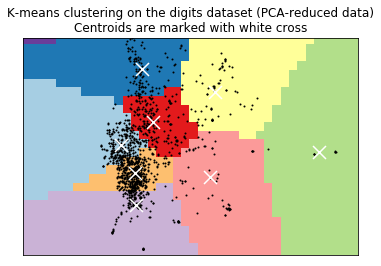

In [62]:
reduced_data = PCA(n_components=2).fit_transform(x_train_2000)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering: 2-grams (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(-.3, .5)
plt.ylim(-.25, .25)
plt.xticks(())
plt.yticks(())
plt.show()

### Try to cluster without transforming data

#### 2-grams

In [12]:
true_k = 15
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_train_tfidf_1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(true_k):
    print("\n\nCluster %d:" % i, "\n")
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:


Cluster 0: 

 engineering
 experience
 data
 software
 engineer
 platform
 engineers
 machine
 systems
 learning


Cluster 1: 

 sales
 territory
 clients
 meet
 enterprise
 prospective
 negotiations
 quota
 solid
 rsm


Cluster 2: 

 solution
 technical
 companies
 sales
 product
 years row
 row
 solution engineer
 experience
 business


Cluster 3: 

 self driving
 driving
 self
 vehicle
 atg
 learning
 pittsburgh
 safety
 hardware
 technologies


Cluster 4: 

 partnerships
 sales
 ubereats
 restaurant
 business
 eats
 experience
 partners
 restaurant partners
 work


Cluster 5: 

 security
 technical
 product
 customer
 sales
 customers
 services
 experience
 ubereats
 identity


Cluster 6: 

 caviar
 point sale
 sale
 point
 payments
 restaurants
 product
 restaurant
 businesses
 seller


Cluster 7: 

 data
 experience
 business
 operations
 models
 work
 support
 driver
 product
 insights


Cluster 8: 

 business
 experience
 tax
 management
 program
 compl

### Investigate how much variance is lost during PCA

Chart of variance explained by additional components:


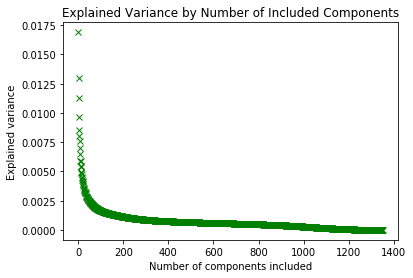

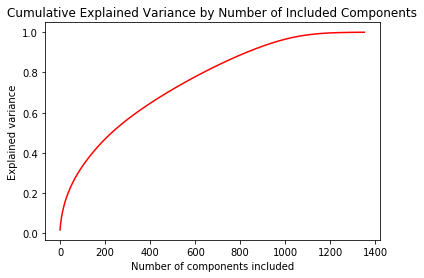

In [74]:

def var_lost_pca():

    pca = PCA(n_components=1352)
    pca.fit(x_train_2000)
    explained_variance = pca.explained_variance_ratio_
    
    component_list = [i for i in range(1352)]
    variance_list = []
    cumulative_variances = []
    print("Chart of variance explained by additional components:")
    for variance in explained_variance:
        variance_list.append(variance)
        cumulative_variances.append(sum(variance_list))
    
    # Plot the explained variance by the number of components included
    plt.xlabel('Number of components included')
    plt.ylabel('Explained variance')
    plt.title('Explained Variance by Number of Included Components')
    plt.plot(component_list,variance_list,'gx')
    plt.show()
    
    # Plot the cumulative explained variance by the number of components included
    plt.xlabel('Number of components included')
    plt.ylabel('Explained variance')
    plt.title('Cumulative Explained Variance by Number of Included Components')
    plt.plot(component_list, cumulative_variances,'r')
    plt.show()
    
#     print("List of cumulative variances:")
#     for index, cum_var in enumerate(cumulative_variances):
#         print("Explained variance with",index+1,"components:",'{:.2%}'.format(cum_var))
                
var_lost_pca()


This is pretty disappointing in two dimensions, but then again, we're talking about _words_ -- there are a lot of features. 

We have a bit more work to do to make these clusters pop.

# TODO

1. Look at the actual words for each document. Amend the stopwords list if necessary.
2. Properly conduct clustering; see how distinct the clusters are
3. Graph in three dimensions in Plotly... possibly color each cluster differently, like this: https://plot.ly/python/3d-point-clustering/
4. Look at lemmatizing and stemming -- more advanced analysis of terms. There are some plurals etc. that should get resolved to the same object.

Print all of the clusters, and the job descriptions (document titles) of each point. Then find the similarities manually to label them as buckets?

## Notes
- Removing company names had a _big_ effect on the cluster results.

# Clean Single Pass

Same procedures as above, plus token-level analysis such as tokenizing and lemmatizing.

In [47]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [52]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/goodgame/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/goodgame/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [60]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [69]:
# vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=custom_stop_words, ngram_range=(1,2), analyzer='word')  
vect = TfidfVectorizer(stop_words=custom_stop_words, tokenizer=stemming_tokenizer, ngram_range=(1,2), analyzer='word')  
transformed_tfidf = vect.fit_transform(dataset.data)
print("\n Here are the dimensions of our two-gram dataset: \n", transformed_tfidf.shape, "\n")


 Here are the dimensions of our two-gram dataset: 
 (1352, 119051) 



In [70]:
true_k = 20
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(transformed_tfidf)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("\n\nCluster %d:" % i, "\n")
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])

Top terms per cluster:


Cluster 0: 

 campaign
 ad
 channel
 media
 market
 mobil
 paid social
 creativ
 digit
 paid
 advertis
 mobil advertis
 perform market
 perform
 display
 agenc
 test
 manag
 brand
 adtech
 dsp
 design
 region
 social
 analyt
 cpc
 data
 market manag
 cpm
 bid
 work
 programmat
 execut
 ltv
 goal execut
 cpa cpc
 cpc cpm
 latam
 media channel
 strategi
 execut tight
 track
 experiment
 budget
 brand campaign
 tight
 product
 emea
 facebook
 countri


Cluster 1: 

 custom
 manag
 busi
 product
 technic
 compani
 develop
 work
 partner
 solut
 abil
 technolog
 market
 servic
 project
 success
 program
 sale
 enterpris
 drive
 requir
 strategi
 commun
 cloud
 skill
 year
 execut
 process
 support
 organ
 includ
 relationship
 intern
 strong
 applic
 lead
 design
 strateg
 engin
 softwar
 provid
 consult
 innov
 function
 leadership
 product manag
 deliveri
 respons
 plan
 ensur


Cluster 2: 

 sale
 client
 prospect
 territori
 meet
 relationship
 plan
 develop
 cl

 driver
 develop
 advanc
 problem
 busi
 analyt
 optim
 experiment
 tool
 python
 rider
 appli
 r
 insight
 oper
 econom
 technic
 process
 decis
 platform
 manag
 market
 predict
 ai
 sql
 marketplac
 challeng
 scale
 background
 product engin
 plu
 commun
 abil


Cluster 19: 

 secur
 vulner
 compani
 infrastructur
 network
 threat
 applic
 work
 servic
 develop
 engin
 manag
 cloud
 tool
 control
 detect
 program
 architectur
 attack
 year row
 linux
 row
 technolog
 code
 technic
 applic secur
 physic secur
 year
 review
 protect
 product
 softwar
 physic
 design
 secur engin
 data
 autom
 knowledg
 access control
 implement
 build
 includ
 assess
 grow
 penetr test
 respons
 new
 penetr
 solut
 harden


In [72]:
# Make data smaller
start_time = time.time()
# For now, using about half of the features
tsvd = TruncatedSVD(n_components=2000)
x_train_2000 = tsvd.fit_transform(transformed_tfidf)

print(x_train_2000.shape)
X_train_tfidf = x_train_2000
print(X_train_tfidf.shape)

end_time = time.time()

print("Time for entire truncating process: ", round(end_time - start_time, 2), "seconds.")

(1352, 1352)
(1352, 1352)
Time for entire truncating process:  137.63 seconds.


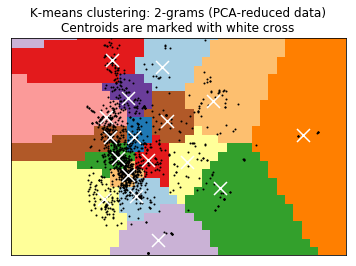

In [75]:
reduced_data = PCA(n_components=2).fit_transform(X_train_tfidf)
kmeans = KMeans(init='k-means++', n_clusters=20, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering: 2-grams (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(-.3, .5)
plt.ylim(-.25, .25)
plt.xticks(())
plt.yticks(())
plt.show()

In [142]:
plotly_data = PCA(n_components=3).fit_transform(X_train_tfidf)
kmeans = KMeans(init='k-means++', n_clusters=15, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [148]:
# for point in plotly_data[:10]:
#     print(point)
#     print(kmeans.fit_predict(point))

mylist = []

for index, item in enumerate(plotly_data):
    mylist.append(np.append(item, kmeans.labels_[index]))

df = pd.DataFrame(mylist)
df.columns = ['x1', 'x2', 'x3', 'y']

In [141]:
# for i in range(1,16):
#     string = '''cluster%s = dict(
#         alphahull = 5,
#         name = "Cluster %s",
#         opacity = .1,
#         type = "mesh3d",    
#         x = cluster%s.as_matrix()[:,0], y = cluster%s.as_matrix()[:,1], z = cluster%s.as_matrix()[:,2],
#         color='green', showscale = True
#     )''' % (i,i,i,i,i)
#     print(string)

## Use Plotly

In [156]:

# Visualize cluster shapes in 3d.
import plotly
import plotly.graph_objs as go

cluster1=df.loc[df['y'] == 0]
cluster2=df.loc[df['y'] == 1]
cluster3=df.loc[df['y'] == 2]
cluster4=df.loc[df['y'] == 3]
cluster5=df.loc[df['y'] == 4]
cluster6=df.loc[df['y'] == 5]
cluster7=df.loc[df['y'] == 6]
cluster8=df.loc[df['y'] == 7]
cluster9=df.loc[df['y'] == 8]
cluster10=df.loc[df['y'] == 9]
cluster11=df.loc[df['y'] == 10]
cluster12=df.loc[df['y'] == 11]
cluster13=df.loc[df['y'] == 12]
cluster14=df.loc[df['y'] == 13]
cluster15=df.loc[df['y'] == 14]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 1",
    type = "scatter3d",    
    x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
    marker = dict( size=2, color='green')
) 
scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
    marker = dict( size=2, color='blue')
) 
scatter3 = dict(
    mode = "markers",
    name = "Cluster 3",
    type = "scatter3d",    
    x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
    marker = dict( size=2, color='red')
) 
scatter4 = dict(
    mode = "markers",
    name = "Cluster 4",
    type = "scatter3d",    
    x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
    marker = dict( size=2, color='cyan')
) 
scatter5 = dict(
    mode = "markers",
    name = "Cluster 5",
    type = "scatter3d",    
    x = cluster5.as_matrix()[:,0], y = cluster5.as_matrix()[:,1], z = cluster5.as_matrix()[:,2],
    marker = dict( size=2, color='yellow')
) 
scatter6 = dict(
    mode = "markers",
    name = "Cluster 6",
    type = "scatter3d",    
    x = cluster6.as_matrix()[:,0], y = cluster6.as_matrix()[:,1], z = cluster6.as_matrix()[:,2],
    marker = dict( size=2, color='orange')
) 
scatter7 = dict(
    mode = "markers",
    name = "Cluster 7",
    type = "scatter3d",    
    x = cluster7.as_matrix()[:,0], y = cluster7.as_matrix()[:,1], z = cluster7.as_matrix()[:,2],
    marker = dict( size=2, color='teal')
) 
scatter8 = dict(
    mode = "markers",
    name = "Cluster 8",
    type = "scatter3d",    
    x = cluster8.as_matrix()[:,0], y = cluster8.as_matrix()[:,1], z = cluster8.as_matrix()[:,2],
    marker = dict( size=2, color='purple')
) 
scatter9 = dict(
    mode = "markers",
    name = "Cluster 9",
    type = "scatter3d",    
    x = cluster9.as_matrix()[:,0], y = cluster9.as_matrix()[:,1], z = cluster9.as_matrix()[:,2],
    marker = dict( size=2, color='brown')
) 
scatter10 = dict(
    mode = "markers",
    name = "Cluster 10",
    type = "scatter3d",    
    x = cluster10.as_matrix()[:,0], y = cluster10.as_matrix()[:,1], z = cluster10.as_matrix()[:,2],
    marker = dict( size=2, color='black')
) 
scatter11 = dict(
    mode = "markers",
    name = "Cluster 11",
    type = "scatter3d",    
    x = cluster11.as_matrix()[:,0], y = cluster11.as_matrix()[:,1], z = cluster11.as_matrix()[:,2],
    marker = dict( size=2, color='pink')
) 
scatter12 = dict(
    mode = "markers",
    name = "Cluster 12",
    type = "scatter3d",    
    x = cluster12.as_matrix()[:,0], y = cluster12.as_matrix()[:,1], z = cluster12.as_matrix()[:,2],
    marker = dict( size=2, color='violet')
) 
scatter13 = dict(
    mode = "markers",
    name = "Cluster 13",
    type = "scatter3d",    
    x = cluster13.as_matrix()[:,0], y = cluster13.as_matrix()[:,1], z = cluster13.as_matrix()[:,2],
    marker = dict( size=2, color='indigo')
) 
scatter14 = dict(
    mode = "markers",
    name = "Cluster 14",
    type = "scatter3d",    
    x = cluster14.as_matrix()[:,0], y = cluster14.as_matrix()[:,1], z = cluster14.as_matrix()[:,2],
    marker = dict( size=2, color='gray')
) 
scatter15 = dict(
    mode = "markers",
    name = "Cluster 15",
    type = "scatter3d",    
    x = cluster15.as_matrix()[:,0], y = cluster15.as_matrix()[:,1], z = cluster15.as_matrix()[:,2],
    marker = dict( size=2, color='crimson')
    ) 
cluster1 = dict(
        alphahull = 5,
        name = "Cluster 1",
        opacity = .1,
        type = "mesh3d",    
        x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
        color='green', showscale = True
    )
cluster2 = dict(
        alphahull = 5,
        name = "Cluster 2",
        opacity = .1,
        type = "mesh3d",    
        x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
        color='blue', showscale = True
    )
cluster3 = dict(
        alphahull = 5,
        name = "Cluster 3",
        opacity = .1,
        type = "mesh3d",    
        x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
        color='red', showscale = True
    )
cluster4 = dict(
        alphahull = 5,
        name = "Cluster 4",
        opacity = .1,
        type = "mesh3d",    
        x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
        color='cyan', showscale = True
    )
cluster5 = dict(
        alphahull = 5,
        name = "Cluster 5",
        opacity = .1,
        type = "mesh3d",    
        x = cluster5.as_matrix()[:,0], y = cluster5.as_matrix()[:,1], z = cluster5.as_matrix()[:,2],
        color='yellow', showscale = True
    )
cluster6 = dict(
        alphahull = 5,
        name = "Cluster 6",
        opacity = .1,
        type = "mesh3d",    
        x = cluster6.as_matrix()[:,0], y = cluster6.as_matrix()[:,1], z = cluster6.as_matrix()[:,2],
        color='orange', showscale = True
    )
cluster7 = dict(
        alphahull = 5,
        name = "Cluster 7",
        opacity = .1,
        type = "mesh3d",    
        x = cluster7.as_matrix()[:,0], y = cluster7.as_matrix()[:,1], z = cluster7.as_matrix()[:,2],
        color='teal', showscale = True
    )
cluster8 = dict(
        alphahull = 5,
        name = "Cluster 8",
        opacity = .1,
        type = "mesh3d",    
        x = cluster8.as_matrix()[:,0], y = cluster8.as_matrix()[:,1], z = cluster8.as_matrix()[:,2],
        color='purple', showscale = True
    )
cluster9 = dict(
        alphahull = 5,
        name = "Cluster 9",
        opacity = .1,
        type = "mesh3d",    
        x = cluster9.as_matrix()[:,0], y = cluster9.as_matrix()[:,1], z = cluster9.as_matrix()[:,2],
        color='brown', showscale = True
    )
cluster10 = dict(
        alphahull = 5,
        name = "Cluster 10",
        opacity = .1,
        type = "mesh3d",    
        x = cluster10.as_matrix()[:,0], y = cluster10.as_matrix()[:,1], z = cluster10.as_matrix()[:,2],
        color='black', showscale = True
    )
cluster11 = dict(
        alphahull = 5,
        name = "Cluster 11",
        opacity = .1,
        type = "mesh3d",    
        x = cluster11.as_matrix()[:,0], y = cluster11.as_matrix()[:,1], z = cluster11.as_matrix()[:,2],
        color='pink', showscale = True
    )
cluster12 = dict(
        alphahull = 5,
        name = "Cluster 12",
        opacity = .1,
        type = "mesh3d",    
        x = cluster12.as_matrix()[:,0], y = cluster12.as_matrix()[:,1], z = cluster12.as_matrix()[:,2],
        color='violet', showscale = True
    )
cluster13 = dict(
        alphahull = 5,
        name = "Cluster 13",
        opacity = .1,
        type = "mesh3d",    
        x = cluster13.as_matrix()[:,0], y = cluster13.as_matrix()[:,1], z = cluster13.as_matrix()[:,2],
        color='indigo', showscale = True
    )
cluster14 = dict(
        alphahull = 5,
        name = "Cluster 14",
        opacity = .1,
        type = "mesh3d",    
        x = cluster14.as_matrix()[:,0], y = cluster14.as_matrix()[:,1], z = cluster14.as_matrix()[:,2],
        color='gray', showscale = True
    )
cluster15 = dict(
        alphahull = 5,
        name = "Cluster 15",
        opacity = .1,
        type = "mesh3d",    
        x = cluster15.as_matrix()[:,0], y = cluster15.as_matrix()[:,1], z = cluster15.as_matrix()[:,2],
        color='crimson', showscale = True
    )

layout = dict(
    title = 'Clusters',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
    ),
    width=750,
    height=750,
    showlegend=False
)
fig = dict( data=[scatter1, scatter2, scatter3, scatter4, scatter5, scatter6, scatter7, scatter8, scatter9, scatter10, scatter11, scatter12, scatter13, scatter14, scatter15, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11, cluster12, cluster13, cluster14, cluster15], layout=layout )
# Use py.iplot() for IPython notebook
plotly.plotly.iplot(fig, filename='clusters')